# 목표 
PyPorch에서 제공하는 GCN 예제를 실습함으로 GCN 구조에 대한 원리를 이해.  

- data.x: 각 노드의 특성(feature) 정보를 담은 행렬로, 크기는 [num_nodes, num_node_features]이다.
- data.edge_index: COO 형태의 그래프 연결 정보를 담은 행렬로, 크기는 [2, num_edges]이다. torch.long 타입을 갖는다.
  - COO란 Coordinate 형태의 희소 행렬(Sparse Matrix)을 나타내는 방법 중 하나
  - 희소행렬 : 대부분의 원소가 0으로 이루어져 있는 행렬을 의미
- data.edge_attr: 각 엣지(간선)의 특성 정보를 담은 행렬로, 크기는 [num_edges, num_edge_features]이다.
- data.y: 학습에 사용할 타겟 정보(target)를 담은 행렬로, 노드 수준의 타겟 정보는 [num_nodes, *]와 같은 형태일 수 있고, 그래프 수준의 타겟 정보는 [1, *]와 같은 형태일 수 있다.
- data.pos: 각 노드의 위치 정보를 담은 행렬로, 크기는 [num_nodes, num_dimensions]이다.

https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#

# Setp.0 GPU 동작 확인

In [ ]:
import torch 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
use_cuda = torch.cuda.is_available()
print(use_cuda)
if use_cuda:
  print(torch.cuda.get_device_name(0))

cuda:0
True
Tesla T4


### Step.1 GNN 설계를 위한 PyTorch 라이브러리 import

Python에서 GNN 모델 설계를 지원하는 다양한 라이브러리들이 존재한다.

1. PyTorch Geometric: PyTorch Geometric는 PyTorch 기반의 GNN 라이브러리로 대규모 그래프에서 GNN을 학습시키기 위한 다양한 유틸리티 함수와 함께 다양한 GNN 모델을 구현할 수 있다.
2. Deep Graph Library (DGL): DGL은 MXNet, PyTorch 및 TensorFlow에서 GNN 모델을 구현하고 학습시키기 위한 라이브러리. 여러 가지 그래프 레이아웃과 함께 다양한 GNN 모델과 레이어를 구현할 수 있다.
3. Spektral: Spektral은 Keras 기반의 GNN 라이브러리로 다양한 GNN 모델을 쉽게 구현하고 학습시킬 수 있다.
4. NetworkX: NetworkX는 Python에서 네트워크 분석을 위한 라이브러리입니다. NetworkX를 사용하여 GNN 모델을 구현하고 학습시킬 수 있다.

In [ ]:
!pip install torch-geometric
#-- pytorch에서 제공하는 Grpah 라이브러리 install

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 616.2/616.2 KB 16.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.3.0-py3-none-any.whl size=909897 sha256=7bf3b375bd17f0752769e43fc1577050b5321b7ee0c73b7c31573d9bd4fc7a15
  Stored in directory: /root/.cache/pip/wheels/cd/7d/6b/17150450b80b4a3656a84330e22709ccd8dc0f8f4773ba4133
Successfully built torch-geometric


In [ ]:
#-- 필요 라이브러리 import 
from torch import Tensor
import torch.nn.functional as F
from torch_geometric.nn import GCNConv #-- PyTorch Geometric은 GNN 모델을 구현하고 학습하는 데 필요한 많은 함수와 모듈을 제공.
from torch_geometric.datasets import Planetoid #-- 실습을 위한 데이터셋 라이브러리 Import 
#-- 대표적인 데이터셋으로는 Cora, Citeseer, Pubmed가 존재하며 해당 실습에서는 Cora데이터셋을 이용
from torch_geometric.utils import to_dense_adj #-- 인접행렬로 바꾸기 위한 라이브러리
from torch_geometric.utils import train_test_split_edges

### Step2. Cora Dataset 다운로드

### Dataset
1. Cora: 컴퓨터 과학 논문 데이터셋으로, 논문을 노드로, 각 논문의 키워드를 feature로 갖고 있다.
2. Citeseer: Cora와 비슷한 데이터셋으로, 컴퓨터 과학 분야의 논문을 노드로, 논문의 키워드를 feature로 갖고 있다.
3. Pubmed: 의학 분야의 논문 데이터셋으로, 논문을 노드로, 논문의 키워드를 feature로 갖고 있다.
4. Reddit: 소셜 미디어 사이트인 Reddit의 서브레딧 데이터셋으로, 각 포스트를 노드로, 사용자가 작성한 텍스트를 feature로 갖고 있다.
5. PPI (Protein-Protein Interaction): 단백질 상호작용 데이터셋으로, 각 단백질을 노드로, 단백질의 특징을 feature로 갖고 있다.

PyTorch Geometric에서는 TUDataset, Planetoid, Coauthor 등 다양한 데이터셋을 제공하고 있고,  DGL에서도 Reddit, Amazon 등 대표적인 GNN 데이터셋을 제공한다.

### Cora 데이터셋은 논문 분류 문제를 해결하기 위해 만들어진 citation network 데이터셋 중 하나로, 대학교의 과목 논문들과 해당 논문들 간의 인용 관계를 그래프로 나타낸 것이다. 총 2708개의 논문이 7개의 범주 중 하나에 속하며, 각 논문은 단어들의 TF-IDF 값을 특징 벡터로 가지고 있다. 이 데이터셋은 GNN 모델을 비롯한 다양한 머신러닝 모델의 성능 평가에 많이 사용되며, 특히 GNN의 레퍼런스로 가장 많이 이용된다.

In [ ]:
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]
# adj_matrix = to_dense_adj(dataset[0].edge_index) #-- 인접행렬로 변환시 사용 하지만 일반적으로 사용하지 않음

### Cora 데이터 확인
- num_features
  - 데이터셋에서 각 노드의 특징(feature)의 수를 나타낸다. 이 값은 각 노드에서 사용할 입력 특징 벡터의 크기를 결정하는 데 사용된다. 예를 들어, Cora 데이터셋의 경우 각 노드는 논문을 나타내며, 노드의 특징은 해당 논문의 단어 빈도수 벡터이다. num_features는 이 벡터의 크기를 나타내며, Cora 데이터셋에서는 1433이다. 따라서 GNN 모델에서 이 데이터셋을 사용할 때, 입력 특징 벡터의 크기도 1433이어야 한다.
- num_classes 
  -  클래스의 수를 나타내는 변수로 해당 데이터셋에서는 7개의 범주가 존재하므로 7이 되어야 한다.

In [ ]:
print("Cora Dataset Number of Classes is", dataset.num_classes)
print("\n")
print("Cora Dataset Number of Features is", dataset.num_features)
# print("adj_matrix", adj_matrix.shape) #-- 2708 X 2708

Cora Dataset Number of Classes is 7


Cora Dataset Number of Features is 1433


### Step.3 GCN 모델 생성

- conv1 레이어
  - in_channels : 각 노드의 특징 벡터들을 입력으로 받는다(input_feature)
  - hidden_channels : 해당 레이어를 통과한 후 나오는 레이어의 채널이다.
    - CNN에서 출력 레이어의 채널과 유사하다.

- Relu
  - 활성화 함수로 Relu를 이용한다.

- conv2
 - hidden_channels : 이전 conv1 레이어에서 통과한 특징들을 입력값으로 받는다(hidden(conv1))
 - out_channels : 모든 레이어를 통과하고 예측을 위한 output값으로 클래스 개수가 들어간다.


X = H(matrix)
Column : 노드의 개수
Row : 각 노드별 특징의 개수이다.

edge_index(희소 행렬)
는 그래프에서 노드들 간의 연결 상태를 나타내는 정보를 담고 있다. 예를 들어, 친구 관계를 그래프로 표현한다고 가정한다면 친구 관계 그래프에서 노드는 사람을 나타내고, 엣지는 친구 관계를 나타낸다. 이때, edge_index는 어떤 두 사람이 친구 관계인지를 알려주는 정보이다.
예를 들어, edge_index가 [0, 1]이라면, 첫 번째 사람과 두 번째 사람이 친구 관계임을 나타내고. 이렇게 edge_index는 그래프의 구성 요소인 노드와 엣지 간의 관계를 나타내는 중요한 정보 중 하나이다.(인접 행렬)  

- adj : 밀집 행렬
- edge_index : 희소 행렬

대규모 그래프의 경우 메모리 소모량이 매우 커질 수 있습니다. 따라서, 인접행렬 대신 edge_index를 직접 사용하는 것이 일반적인 방법이다.


GNN 모델 자체가 그래프 내의 각 노드에 대한 정보를 업데이트하면서 점진적으로 전파하기 때문에, 레이어가 깊어질수록 이전의 정보가 현재 노드에 영향을 미치는 정도가 감소한다. 이를 해결하기 위해 Residual connection 등의 기법을 사용할 수 있지만, 여전히 얕은 모델이 깊은 모델보다 더 나은 성능을 보이는 경우가 많다.

따라서 GNN에서는 일반적으로 레이어를 얕게 쌓는 경향이 있습니다. 그러나 데이터셋의 복잡도에 따라서는 더 깊은 모델이 필요할 수도 있다. 이는 데이터셋에 따라 다르기 때문에, 실험을 통해 최적의 모델 구조를 찾아내는 것이 중요하다.

In [ ]:
class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 16)
        self.conv2 = GCNConv(16, dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [ ]:
#-- data를 GPU로 이동
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = GCN().to(device)
data = dataset[0].to(device)
#-- data를 GPU로 이동


optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
epochs = 20

#-- 모델 학습 시작
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

In [ ]:
#-- 테스트 데이터로 모델 평가 
model.eval()
pred = model(data).argmax(dim=1)
correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
acc = int(correct) / int(data.test_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 0.8020


# Step4. 데이터 시각화

입력으로는 G라는 네트워크 그래프와 각 노드에 적용할 색상 맵(color_map)을 받는다. pos 변수에는 nx.spring_layout() 함수를 사용하여 노드의 좌표 정보를 얻는다. 그 후 nx.draw_networkx_nodes() 함수와 nx.draw_networkx_edges() 함수를 사용하여 노드와 엣지를 그리고, nx.draw_networkx_labels() 함수를 사용하여 노드에 해당하는 숫자를 그린다.
마지막으로 plt.show() 함수를 호출하여 시각화한 그래프를 출력하여, 해당 그래프의 구조와 노드 간의 관계를 직관적으로 이해할 수 있다.

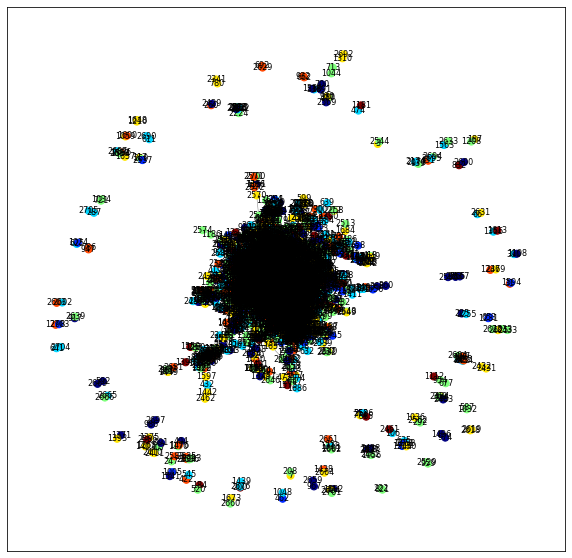

In [ ]:
import networkx as nx
#--  파이썬에서 그래프와 네트워크를 다루기 위한 라이브러리
import matplotlib.pyplot as plt

def visualize_graph(G, color_map):
    plt.figure(figsize=(10,10))

    #-- 노드의 좌표 정보를 얻음.
    pos = nx.spring_layout(G)

    #-- 노드와 엣지를 시각화.
    nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('jet'), node_color=color_map, node_size=50)
    nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.5)

    #-- 노드에 해당하는 숫자를 그립.
    labels = {}
    for node in G.nodes():
        labels[node] = str(node)
    nx.draw_networkx_labels(G, pos, labels, font_size=8)
    
    plt.show()


model.eval()
_, pred = model(data).max(dim=1)

#-- 시각화 함수를 이용하여 그래프를 출력합니다.
visualize_graph(nx.from_edgelist(data.edge_index.T.tolist()), pred.cpu().numpy())


In [ ]:
import plotly.graph_objs as go
import plotly.io as pio

def visualize_graph(G, color_map):
    #-- 노드의 좌표 정보를 얻음.
    pos = nx.spring_layout(G)

    #-- 노드와 엣지를 시각화.
    edge_trace = go.Scatter(x=(), y=(), line=dict(width=0.5, color='#888'))
    for edge in G.edges():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_trace['x'] += (x0, x1, None)
        edge_trace['y'] += (y0, y1, None)

    node_trace = go.Scatter(x=(), y=(), text=(), mode='markers', 
                            hoverinfo='text', marker=dict(showscale=False, colorscale='YlGnBu', reversescale=True, color=(), size=10, colorbar=dict(thickness=15, title='Node Connections', xanchor='left', titleside='right'), line_width=2))

    for node in G.nodes():
        x, y = pos[node]
        node_trace['x'] += (x,)
        node_trace['y'] += (y,)
        node_trace['text'] += (str(node),)
        node_trace['marker']['color'] += (color_map[node],)

    #-- 그래프 출력.
    fig = go.Figure(data=[edge_trace, node_trace], layout=go.Layout(title='Graph Visualization', 
                                                                   titlefont_size=16, 
                                                                   showlegend=False, 
                                                                   hovermode='closest', 
                                                                   margin=dict(b=20,l=5,r=5,t=40),
                                                                   annotations=[dict(text="Python code: <a href='https://colab.research.google.com/github/alanjeffares/pytorch-GAT/blob/master/PyTorch%20Geometric%20(GAT)%20CoLaboratory.ipynb'> (source) </a>", showarrow=False, xref="paper", yref="paper", x=0.005, y=-0.002)]))
    fig.update_layout(width=800, height=800)
    pio.show(fig)

visualize_graph(nx.from_edgelist(data.edge_index.cpu().T.numpy().tolist()), pred.cpu().numpy())